In [13]:
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [68]:
factor_labels = {
    't_awake': 0,
    'fasting': 1,
    'coffee': 2,
    't_run': 3,
}

In [9]:
design_mat = np.loadtxt('/content/design_mat.txt')
response = np.loadtxt('/content/response.txt')
control_runs = np.loadtxt('/content/control_runs.txt')

In [26]:
run_order = np.hstack((control_runs.reshape(-1,1), response.reshape(-1,1))).flatten()

In [10]:
design_mat

array([[-1.,  1., -1.,  1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1.,  1.,  1.],
       [ 1., -1.,  1., -1.],
       [-1., -1., -1., -1.],
       [-1.,  1.,  1., -1.],
       [-1., -1.,  1.,  1.],
       [ 1., -1., -1.,  1.]])

In [11]:
response

array([153.4, 159.8, 156.2, 173.6, 176.5, 161.8, 173.4, 166.1])

In [12]:
control_runs

array([153.53237131, 161.32874687, 156.22402598, 158.45331008,
       160.11202582, 159.02579784, 154.72158358, 157.37700207])

# EDA

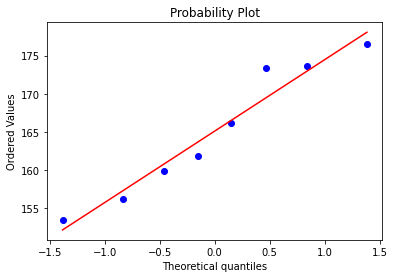

In [14]:
 stats.probplot(response, dist="norm", plot=pylab)
pylab.show()

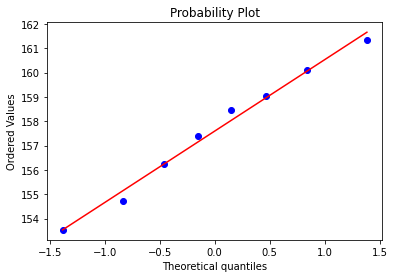

In [16]:
stats.probplot(control_runs, dist="norm", plot=pylab)
pylab.show()

We see that both the trial run and control run response values are very nearly normally-distributed.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


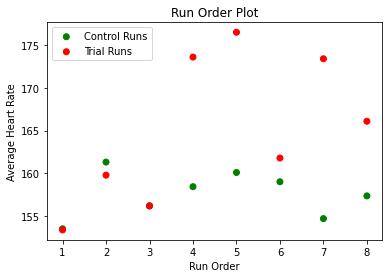

In [47]:
n = run_order.shape[0]
x_axis = [[i] for i in range(1, int(n / 2) + 1)]
plt.scatter(x_axis, control_runs, color='g' * int(n/2), label='Control Runs')
plt.scatter(x_axis, response, color='r' * int(n/2), label='Trial Runs')
plt.title('Run Order Plot')
plt.xlabel('Run Order')
plt.ylabel('Average Heart Rate')
plt.legend()
plt.show()

We see that the control run values are roughly stable throughout the experiment, with no obvious increase over time, suggesting that the chosen wash-out period of one day between trials is in fact a sufficient rest period. We also note that four of the trial runs are associated with markedly elevated response values even as the control runs associated with them are not noticeably elevated above the other control runs. This suggests that the factor levels associated with runs 4, 5, 7, and 8 lead to an increased average heart rate over those associated with the other four trial runs.

In [54]:
low_factor = response[design_mat[:,i] == -1]
high_factor= response[design_mat[:,i] == -1]

array([153.4, 176.5, 161.8, 173.4])

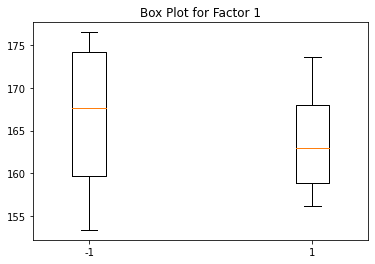

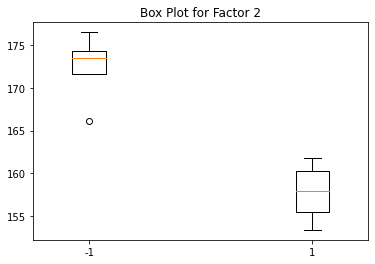

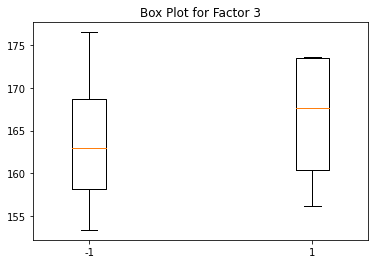

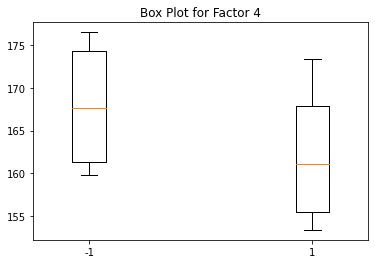

In [71]:
n_factors = design_mat.shape[1]
for i in range(n_factors):
    low_factor = response[design_mat[:,i] == -1]
    high_factor= response[design_mat[:,i] == 1]
    factors = np.hstack((low_factor.reshape(-1,1), high_factor.reshape(-1,1)))
    plt.boxplot(factors, positions=(-1,1), )
    plt.title('Box Plot for Factor %s' % int(i+1))
    plt.show()

We see a marked difference in average response between the low and high levels of factor two, and a slightly smaller though still noticeable separation for factors four and three. Factor one appears to have no clear separation between the levels, algthough the variance in the low level runs is greater than in the high level runs.

# Fit Linear Models

In [74]:
colnames = list(factor_labels.keys()) + ['heart_rate']
data = pd.DataFrame(np.hstack((design_mat, response.reshape(-1,1))), columns=colnames)
data

,t_awake,fasting,coffee,t_run,heart_rate
0,-1.0,1.0,-1.0,1.0,153.4
1,1.0,1.0,-1.0,-1.0,159.8
2,1.0,1.0,1.0,1.0,156.2
3,1.0,-1.0,1.0,-1.0,173.6
4,-1.0,-1.0,-1.0,-1.0,176.5
5,-1.0,1.0,1.0,-1.0,161.8
6,-1.0,-1.0,1.0,1.0,173.4
7,1.0,-1.0,-1.0,1.0,166.1


In [75]:
from statsmodels.formula.api import ols


mod = ols('heart_rate ~ t_awake + fasting + coffee + t_run', data=data)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             heart_rate   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     24.94
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0123
Time:                        21:08:39   Log-Likelihood:                -13.969
No. Observations:                   8   AIC:                             37.94
Df Residuals:                       3   BIC:                             38.33
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    165.1000      0.801    206.174      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


We see that factors two and four (`fasting` and `t_run`, respectively) are associated with effects which are signficant at the $5\%$ level, whereas factors one and three are not.

Thus it appears that `fasting` has a large negative effect on heart rate. Runs 4, 5, 7, and 8, in which I was not fasting, had noticeable spikes in heart rate. To test this, we re-fit with just the fasting indicator and `t_run`:

In [88]:
from statsmodels.formula.api import ols


mod = ols('heart_rate ~ fasting + t_run', data=data)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             heart_rate   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     33.11
Date:                Fri, 03 Dec 2021   Prob (F-statistic):            0.00131
Time:                        21:27:13   Log-Likelihood:                -17.479
No. Observations:                   8   AIC:                             40.96
Df Residuals:                       5   BIC:                             41.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    165.1000      0.962    171.628      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


Looking at the R-squared value and noting that all of the effects are significant, it appears that this simpler model has a satisfactory fit.

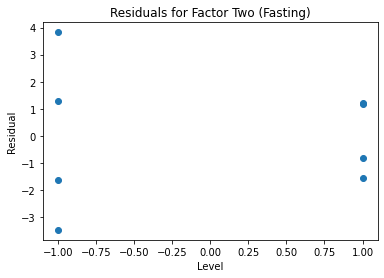

In [92]:
plt.scatter(data['fasting'], res.resid)
plt.title('Residuals for Factor Two (`fasting`)')
plt.xlabel('Level')
plt.ylabel('Residual')
plt.show()

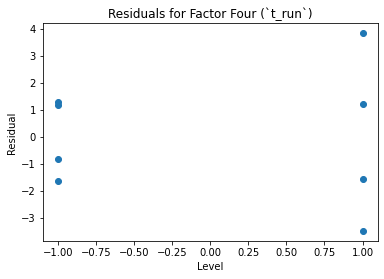

In [93]:
plt.scatter(data['t_run'], res.resid)
plt.title('Residuals for Factor Four (`t_run`)')
plt.xlabel('Level')
plt.ylabel('Residual')
plt.show()

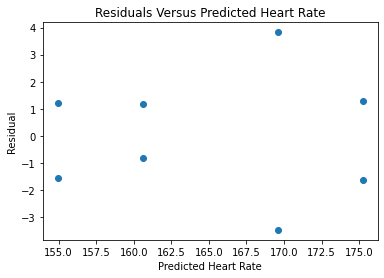

In [97]:
plt.scatter(res.fittedvalues, res.resid)
plt.title('Residuals Versus Predicted Heart Rate')
plt.xlabel('Predicted Heart Rate')
plt.ylabel('Residual')
plt.show()

We see that the residuals associated with the model fit are evenly distributed about the origin. Note that the pairing present in the residual plots is a product of the design itself.

# Conclusions

Based on the above analysis, factors two and four appear to have a significant effect on average heart rate during exercise, whereas factors one and three do not. 

We see that factor two is a associated with a large negative effect on average heart rate, which suggests that running while fasting leads to a reduced average heart rate versus running on a full stomach. 

We also see that factor four is associated with a negative effect on the response, suggesting that taking a day off between runs may lead to a lower average heart rate during the exercise.

Anecdotally, running with a full stomach certainly feels much more difficult than running on an empty stomach, as does running on back to back days. This suggests that the results obtained are in accord with my own experience.

In [401]:
paces = np.loadtxt('/content/paces.txt')
paces_c, paces_t = paces.reshape(-1,2).T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  after removing the cwd from sys.path.


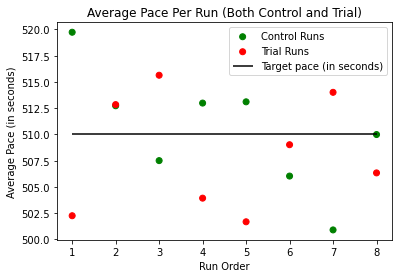

In [402]:
n = run_order.shape[0]
x_axis = [[i] for i in range(1, int(n / 2) + 1)]
plt.scatter(x_axis, paces_c, color='g' * int(n/2), label='Control Runs')
plt.scatter(x_axis, paces_t, color='r' * int(n/2), label='Trial Runs')
plt.title('Average Pace Per Run (Both Control and Trial)')
plt.xlabel('Run Order')
plt.ylabel('Average Pace (in seconds)')
plt.hlines(510, 1, 8, label='Target pace (in seconds)')
plt.legend()
plt.show()

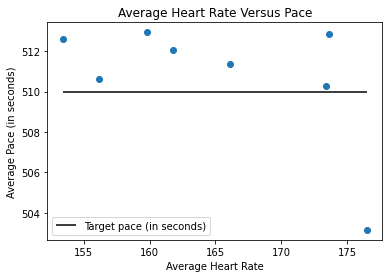

In [403]:
plt.scatter(data['heart_rate'], data['pace'])
plt.title('Average Heart Rate Versus Pace')
plt.xlabel('Average Heart Rate')
plt.ylabel('Average Pace (in seconds)')
min_hr = data['heart_rate'].min()
max_hr = data['heart_rate'].max()
plt.hlines(510, min_hr, max_hr, label='Target pace (in seconds)')
plt.legend()
plt.show()

In [404]:
data['pace'] = paces_t

In [405]:
from statsmodels.formula.api import ols


mod = ols('heart_rate ~ pace', data=data)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             heart_rate   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.085
Method:                 Least Squares   F-statistic:                    0.4518
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.526
Time:                        22:53:25   Log-Likelihood:                -27.813
No. Observations:                   8   AIC:                             59.63
Df Residuals:                       6   BIC:                             59.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    377.7200    316.331      1.194      0.2

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


Unsurprisingly, pace appears to be (slightly) negatively correlated with average heart rate (i.e. as one runs faster, one's heart rate increases). The effect, however, is very small, likely resulting from the small variation in pace between runs.

In [409]:
np.std(data['pace'])

5.134754387021429

With the standard deviation above, roughly 5 seconds per mile or less than one percent of the average pace, it is likely that the differences in heart rate attributable to differences in pace would be small, which is borne out by the results of the regression above. If I had not attempted to match pace between runs, then we would expect to identify a much stronger relationship between pace and heart rate. But because there is little variation in pace, the effect of other factors on average heart rate appears to outweigh that of pace in this sample. To verify that the results of the analysis above are not significantly affected by `pace`, we add `pace` to the full regression model as a covariate.

In [406]:
from statsmodels.formula.api import ols


mod = ols('heart_rate ~ t_awake + fasting + coffee + t_run + pace', data=data)
res = mod.fit()
table = sm.stats.anova_lm(res, typ=2)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             heart_rate   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     47.22
Date:                Fri, 03 Dec 2021   Prob (F-statistic):             0.0209
Time:                        22:53:25   Log-Likelihood:                -8.9857
No. Observations:                   8   AIC:                             29.97
Df Residuals:                       2   BIC:                             30.45
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0227     72.844      0.041      0.9

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


We see that, in the extended model, the factors `fasting` and `t_run` (factors two and four, respectively) are again significant at the $5\%$ level, whereas the other two are not. This matches the results of model fit without `pace` as a covariate.